In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv("/Users/simonmech/Documents/Technocolabs work/prosperLoanData (1).csv") # the full dataset

### Dropped column names

In [3]:
dropped = ['ListingNumber', 'LoanNumber', 'GroupKey', 'LoanKey', 'MemberKey', 'ListingKey']

In [4]:
for col in data.columns :
    if (data[col].isnull().sum() > 0) and col not in dropped:
        sum_null = data[col].isnull().sum()
        percent_null = (sum_null/data.shape[0]) * 100
        if percent_null > 70 :
            dropped.append(col)

## Data Preprocessing

### Imputing `CreditGrade` & `ProsperRating (Alpha)` 

In [5]:
data['CreditGrade'].fillna(data['ProsperRating (Alpha)'],inplace=True)

In [6]:
dropped.extend(['ProsperRating (Alpha)','ProsperRating (numeric)'])
dropped.remove('CreditGrade')

In [7]:
data.drop(dropped,axis=1,inplace=True)

### Filling missing values

In [8]:
data.isnull().sum().sort_values(ascending=False)

ClosedDate                 58848
EstimatedReturn            29084
ProsperScore               29084
EstimatedEffectiveYield    29084
EstimatedLoss              29084
                           ...  
LenderYield                    0
BorrowerRate                   0
LoanStatus                     0
Term                           0
Investors                      0
Length: 64, dtype: int64

In [9]:
for col in data.select_dtypes('float64').columns:
    if data[col].isnull().sum() > 0: 
        data[col].fillna(data[col].median(),inplace=True)
data.select_dtypes('float64').isnull().sum().sum()

0

In [10]:
for col in data.select_dtypes('int64').columns: 
    if data[col].nunique() > 100:
        data[col].fillna(data[col].median(), inplace=True)
    else:
        data[col].fillna(data[col].mode(), inplace=True)
data.select_dtypes('int64').isnull().sum().sum()

0

In [11]:
for col in data.columns :
    if data[col].isnull().sum() > 0 :
        data[col].fillna(data[col].mode()[0],inplace=True)
data.isnull().sum().sum()

0

### Imputing Dates

In [12]:
date =['FirstRecordedCreditLine','DateCreditPulled','ListingCreationDate','ClosedDate','LoanOriginationDate']
# convert date columns from object to datetime 
for i in date:
    #to get ride of time convert data to datetime
    data[i]=pd.to_datetime(data[i])
    data[i]=data[i].dt.date  # datatype=object
    # split each coloumn to year month day then delet it 
    data[f'{i}_year']= pd.DatetimeIndex(data[f'{i}']).year
    data[f'{i}_month']= pd.DatetimeIndex(data[f'{i}']).month
    data[f'{i}_day']= pd.DatetimeIndex(data[f'{i}']).day
    del(data[f'{i}'])

### Detecting Outliers

In [13]:
for col in data.columns:
        if (((data[col].dtype)=='float64') | ((data[col].dtype)=='int64')):
            percentiles = data[col].quantile([0.25,0.75]).values
            iqr = percentiles[1] - percentiles[0]
            lower_bound = percentiles[0] -(1.5 * iqr) 
            upper_bound = percentiles[1] +(1.5 * iqr)
            data[col].loc[data[col] < lower_bound] = lower_bound
            data[col].loc[data[col] > upper_bound] = upper_bound
        else:
            data[col]=data[col]

/var/folders/t0/0gjbrhd51tq6k8dbyrvtgx4w0000gn/T/ipykernel_2088/109602084.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col].loc[data[col] < lower_bound] = lower_bound
/var/folders/t0/0gjbrhd51tq6k8dbyrvtgx4w0000gn/T/ipykernel_2088/109602084.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col].loc[data[col] > upper_bound] = upper_bound


### Imputing Target Value

In [14]:
def target_handling(row): 
    if row == 'Completed':
        return 1
    else:
        return 0

data['Status'] = data['LoanStatus'].apply(target_handling)
data.drop('LoanStatus',axis=1,inplace=True)

### Encoding 

In [15]:
obj = data.select_dtypes('object')
obj.nunique()

CreditGrade                8
BorrowerState             51
Occupation                67
EmploymentStatus           8
IncomeRange                8
LoanOriginationQuarter    33
dtype: int64

In [16]:
### one hot encoding
dummies = pd.get_dummies(data[['CreditGrade', 'EmploymentStatus', 'IncomeRange','LoanOriginationQuarter']], drop_first=True)

In [17]:
## label enc
le = LabelEncoder()
data[['BorrowerState','Occupation']] = data[['BorrowerState','Occupation']].apply(le.fit_transform)

In [18]:
data = pd.concat([data.drop(obj,axis=1),dummies],axis=1)

In [19]:
data.select_dtypes('object')

""
0
1
2
3
4
...
113932
113933
113934
113935


In [20]:
data

,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory (numeric),EmploymentStatusDuration,...,LoanOriginationQuarter_Q3 2013,LoanOriginationQuarter_Q4 2005,LoanOriginationQuarter_Q4 2006,LoanOriginationQuarter_Q4 2007,LoanOriginationQuarter_Q4 2008,LoanOriginationQuarter_Q4 2009,LoanOriginationQuarter_Q4 2010,LoanOriginationQuarter_Q4 2011,LoanOriginationQuarter_Q4 2012,LoanOriginationQuarter_Q4 2013
0,36,0.16516,0.1580,0.1380,0.16150,0.0724,0.09170,6.0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,36,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,7.0,2,44.0,...,0,0,0,0,0,0,0,0,0,0
2,36,0.28269,0.2750,0.2400,0.16150,0.0724,0.09170,6.0,0,67.0,...,0,0,0,0,0,0,0,0,0,0
3,36,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,9.0,6,113.0,...,0,0,0,0,0,0,0,0,1,0
4,36,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,4.0,2,44.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113932,36,0.22354,0.1864,0.1764,0.16490,0.0699,0.09500,5.0,1,246.0,...,0,0,0,0,0,0,0,0,0,0
113933,36,0.13220,0.1110,0.1010,0.10070,0.0200,0.08070,8.0,6,21.0,...,0,0,0,0,0,0,0,1,0,0
113934,36,0.23984,0.2150,0.2050,0.18828,0.1025,0.08578,3.0,1,84.0,...,0,0,0,0,0,0,0,0,0,1
113935,36,0.28408,0.2605,0.2505,0.24450,0.0850,0.15142,5.0,2,94.0,...,0,0,0,0,0,0,0,1,0,0


### Feature Selection

In [21]:
corrlation = data.corrwith(data['Status']).sort_values(ascending = False)
sel_col = corrlation[(corrlation > 0.2) | (corrlation < -0.2)]
sel_col.drop('Status',inplace=True)

In [22]:
sel_col

LP_CustomerPrincipalPayments      0.598982
LoanMonthsSinceOrigination        0.510850
LP_CustomerPayments               0.495638
ClosedDate_day                    0.490288
ClosedDate_month                  0.402958
EmploymentStatus_Full-time        0.379045
Investors                         0.209813
MonthlyLoanPayment               -0.211909
LoanOriginationQuarter_Q1 2014   -0.240852
LoanOriginalAmount               -0.246836
LoanOriginationQuarter_Q4 2013   -0.248185
ClosedDate_year                  -0.465317
DateCreditPulled_year            -0.507319
LoanOriginationDate_year         -0.508132
ListingCreationDate_year         -0.508645
dtype: float64

## Model training 

In [43]:
X = data[sel_col.index]
y= data['Status']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [45]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import GaussianNB


# instantiate the model
gnb = GaussianNB()


# fit the model
gnb.fit(X_train, y_train)

GaussianNB()

Predict the results

In [46]:
y_pred = gnb.predict(X_test)

y_pred

array([0, 1, 0, ..., 0, 0, 1])

Check accuracy score 

In [47]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.8268


Here, y_test are the true class labels and y_pred are the predicted class labels in the test-set.

### Compare the train-set and test-set accuracy



Now, I will compare the train-set and test-set accuracy to check for overfitting.


In [54]:
y_pred_train = gnb.predict(X_train)

y_pred_train

array([0, 1, 0, ..., 0, 0, 1])

In [55]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))


Training-set accuracy score: 0.8244


Check for overfitting and underfitting

In [50]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(gnb.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(gnb.score(X_test, y_test)))

Training set score: 0.8244
Test set score: 0.8268


The training-set accuracy score is 0.8244 while the test-set accuracy to be 0.8268. These two values are quite comparable. So, there is no sign of overfitting.

### Compare model accuracy with null accuracy

So, the model accuracy is 0.8268. But, we cannot say that our model is very good based on the above accuracy. We must compare it with the null accuracy. Null accuracy is the accuracy that could be achieved by always predicting the most frequent class.

In [56]:
# check class distribution in test set

y_test.value_counts()

0    24959
1    12641
Name: Status, dtype: int64

We can see that the occurences of most frequent class is 24959. So, we can calculate null accuracy by dividing 24959 by total number of occurences.

In [58]:
# check null accuracy score

null_accuracy = (24959/(24959+12641))

print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.6638


We can see that our model accuracy score is 0.8268 but null accuracy score is 0.6638. So, we can conclude that our Gaussian Naive Bayes Classification model is doing a very good job in predicting the class labels.



Now, based on the above analysis we can conclude that our classification model accuracy is very good. Our model is doing a very good job in terms of predicting the class labels.

But, it does not give the underlying distribution of values. Also, it does not tell anything about the type of errors our classifer is making.

We have another tool called Confusion matrix that comes to our rescue.



In [59]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[19900  5059]
 [ 1452 11189]]

True Positives(TP) =  19900

True Negatives(TN) =  11189

False Positives(FP) =  5059

False Negatives(FN) =  1452


<AxesSubplot:>

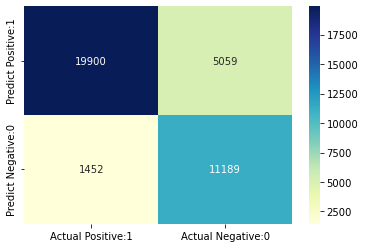

In [60]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# Classification metrices

In [62]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.80      0.86     24959
           1       0.69      0.89      0.77     12641

    accuracy                           0.83     37600
   macro avg       0.81      0.84      0.82     37600
weighted avg       0.85      0.83      0.83     37600

